**PHASE 1 — Environment & Dataset Setup**

1. Enable GPU

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2. Install Required Libraries

In [ ]:
!pip install -q tensorflow opencv-python matplotlib seaborn scikit-learn


3. Dataset Setup (Kaggle)

Upload Kaggle API Key
1.   Kaggle → Account → Create New API Token
2.   Upload kaggle.json to Colab



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Verify Kaggle Is Working

In [ ]:
!kaggle datasets list | head

ref                                                               title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                          3491  2025-12-11 15:29:14.327000           2114        220  1.0              
ahmeduzaki/wind-and-solar-energy-production-dataset               Wind & Solar Energy Production Dataset               395372  2026-01-02 21:06:22.780000              0         42  1.0              
kundanbedmutha/exam-score-prediction-dataset                      Exam Score Prediction Dataset                        325454  2025-11-28 07:29:01.047000           5863        262  1.0              
neuro

Download Dataset

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

⚠️ The PNEUMONIA folder contains bacterial + viral images → multi-class will be handled via subfolders.

**PHASE 2 — Data Preprocessing & Augmentation**

4. Define Paths

In [ ]:
import os

BASE_DIR = "chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

5. Image Generators (Multi-Class)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Check class mapping:

In [ ]:
print("Class mapping:",train_gen.class_indices)
print("Number of classes:",train_gen.num_classes)

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Number of classes: 2


**PHASE 3 — Baseline CNN (Comparison Model)**

⚠️ This model is not final.
Its purpose is benchmarking against DenseNet later.

6. Build Baseline CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten

num_classes = train_gen.num_classes

baseline_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7. Compile & Train

In [ ]:
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("\nTraining Baseline Model....")
history = baseline_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


Training Baseline Model....


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 840ms/step - accuracy: 0.8290 - loss: 3.9989 - val_accuracy: 0.5000 - val_loss: 100.4945
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 816ms/step - accuracy: 0.8853 - loss: 0.3485 - val_accuracy: 0.5000 - val_loss: 51.5548
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 837ms/step - accuracy: 0.8854 - loss: 0.2560 - val_accuracy: 0.5625 - val_loss: 11.2741
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 810ms/step - accuracy: 0.8772 - loss: 0.3313 - val_accuracy: 0.6250 - val_loss: 0.8057
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 622ms/step - accuracy: 0.9066 - loss: 0.2417 - val_accuracy: 0.5000 - val_loss: 1.1600
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9040 - loss: 0.2373 - val_accuracy: 0.8125 - val_loss: 0.3902
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.9097 - loss: 0.2395 - val_accuracy: 0.5000 - val_loss: 72.3197
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9222

8. Baseline Evaluation

In [ ]:
print("\nEvaluating Baseline Model....")
test_loss, test_acc = baseline_model.evaluate(test_gen)
print(f"Baseline Test Accuracy: {test_acc:.4f}")
print(f"Baseline Test Loss: {test_loss:.4f}")


Evaluating Baseline Model....
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.4140 - loss: 2.2123
Baseline Test Accuracy: 0.6827
Baseline Test Loss: 1.1383


Save model:

In [ ]:
baseline_model.save("baseline_cnn_model.keras")
print("Baseline model saved!")

Baseline model saved!


**NEXT PHASE (CRITICAL & HIGH-VALUE)
PHASE 4 — Transfer Learning (DenseNet121)**

I will:

Replace baseline with DenseNet121

Fine-tune layers

Improve recall & AUC

Prepare for deployment

9. Build DenseNet121 Model (Multi-Class)

Import Required Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

Load Pretrained Base Model

In [ ]:
print("\nBuilding DenseNet121 Transfer Learning Model...")
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False  # Freeze base model initially


Building DenseNet121 Transfer Learning Model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Add Custom Classification Head

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

10. Compile Model (Initial Training)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

11. Train Top Layers

In [ ]:
print("\nTraining top layers (base frozen)....")
history_tl = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


Training top layers (base frozen)....
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 701ms/step - accuracy: 0.7812 - loss: 0.5030 - val_accuracy: 0.7500 - val_loss: 0.4273
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 602ms/step - accuracy: 0.9010 - loss: 0.2400 - val_accuracy: 0.7500 - val_loss: 0.4781
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.9216 - loss: 0.1896 - val_accuracy: 0.7500 - val_loss: 0.3463
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9344 - loss: 0.1729 - val_accuracy: 0.7500 - val_loss: 0.4169
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.9331 - loss: 0.1689 - val_accuracy: 0.7500 - val_loss: 0.3554
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 598ms/step - accuracy: 0.9450 - loss: 0.1527 - val_accuracy: 0.7500 - val_loss: 0.3440
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 599ms/step - accuracy: 0.9413 - loss: 0.1483 - val_accuracy: 0.8125 - val_loss: 0.3611
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s

**PHASE 5 — Fine-Tuning (Performance Boost)**

12. Unfreeze Last Layers

In [ ]:
print("\nUnfreezing last 30 layers for fine-tuning....")
base_model.trainable = True
#Freeze all layers except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}")


Unfreezing last 30 layers for fine-tuning....
Total layers: 427
Trainable layers: 30


13. Recompile (Lower LR)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

14. Fine-Tune

In [ ]:
print("\nFine-tuning model....")
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


Fine-tuning model....
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 675ms/step - accuracy: 0.9129 - loss: 0.2119 - val_accuracy: 0.8125 - val_loss: 0.3142
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.9431 - loss: 0.1529 - val_accuracy: 0.7500 - val_loss: 0.3405
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.9431 - loss: 0.1499 - val_accuracy: 0.7500 - val_loss: 0.3020
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.9489 - loss: 0.1403 - val_accuracy: 0.8125 - val_loss: 0.3006
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9565 - loss: 0.1245 - val_accuracy: 0.8125 - val_loss: 0.2890
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.9531 - loss: 0.1245 - val_accuracy: 0.8125 - val_loss: 0.2703
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 603ms/step - accuracy: 0.9510 - loss: 0.1320 - val_accuracy: 0.8125 - val_loss: 0.2411
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - ac

15. Save Final Model

In [ ]:
model.save("pneumonia_multiclass_densenet_model.keras")
print("Final model saved")

Final model saved


**PHASE 6 — Medical-Grade Evaluation**

16. Predictions

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("\nGenerating Predictions on test set....")
test_gen.reset()
y_pred_probs = model.predict(test_gen,verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

#Get class names in correct order
class_names=list(test_gen.class_indices.keys())


Generating Predictions on test set....
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 821ms/step


17. Classification Report

In [ ]:
print("\n" +"="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL       0.96      0.75      0.84       234
   PNEUMONIA       0.87      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



18. Confusion Matrix

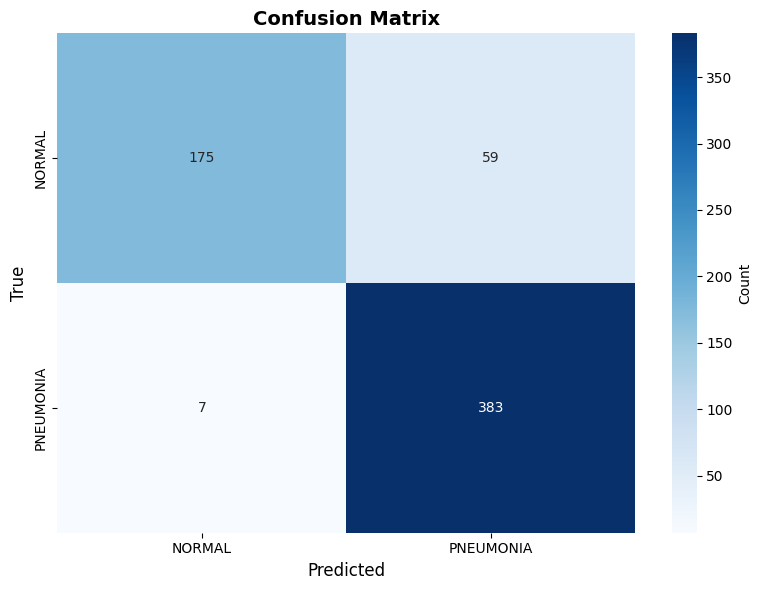


KEY MEDICAL METRICS
Sensitivity (Recall):,0.9821
Specificity:,0.7479
Precision:,0.8665
F1-Score:,0.9207
Accuracy:,0.8942


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label':'Count'})
plt.xlabel("Predicted",fontsize=12)
plt.ylabel("True",fontsize=12)
plt.title("Confusion Matrix",fontsize=14,fontweight='bold')
plt.tight_layout()
plt.show()

#Calculate and display key metrics
tn,fp,fn,tp = cm.ravel() if cm.shape==(2,2) else (cm[0,0],cm[0,1],cm[1,0],cm[1,1])
sensitivity = tp/(tp+fn) #Recall for PNEUMONIA
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fp+fn)
f1 = 2*(precision*sensitivity)/(precision+sensitivity)

print("\n"+"="*60)
print("KEY MEDICAL METRICS")
print("="*60)
print(f"Sensitivity (Recall):,{sensitivity:.4f}")
print(f"Specificity:,{specificity:.4f}")
print(f"Precision:,{precision:.4f}")
print(f"F1-Score:,{f1:.4f}")
print(f"Accuracy:,{accuracy:.4f}")

**PHASE 7 — Grad-CAM (Model Explainability)**

**Why Grad-CAM is Critical**

In medical AI, predictions alone are not enough.

**Grad-CAM:**

*   Shows where the model is looking
*   Builds trust
*   Helps debug wrong predictions


I used Grad-CAM to visualize lung regions influencing the pneumonia classification.

Import Required Libraries

In [ ]:
import cv2

Load Trained Model

(If kernel restarted)

In [ ]:
model = tf.keras.models.load_model("pneumonia_multiclass_densenet_model.keras")

19. Grad-CAM Function

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for model interpretability
    """
    #Create gradient model
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    #Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get gradient
    grads = tape.gradient(class_channel, conv_outputs)

    #Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    #Weight feature maps by gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    #Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap)+1e-10)

    return heatmap.numpy()

20. Overlay Heatmap on Image

In [ ]:
def overlay_gradcam(img_path, heatmap, alpha=0.4):
  """
  Overlay Grad-CAM heatmap on original image
  """
  #load and resize image
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224,224))

  #resize heatmap to match image
  heatmap = cv2.resize(heatmap, (224,224))
  heatmap = np.uint8(255 * heatmap)

  #apply colormap
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  #overlay
  overlay = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

  return overlay,img,heatmap

21. Visualize Grad-CAM for Sample Image

In [ ]:
def visualize_gradcam_samples(model,test_gen,last_conv_layer,num_samples=3):
  """
  Visulaize Grad-CAM for multiple test samples
  """
  plt.figure(figsize=(15,num_samples*4))

  for idx in range(num_samples):
    #get image path
    img_path = test_gen.filepaths[idx]

    #load and preprocess image
    img=tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)/ 255.0

    #get prediction
    predictions=model.predict(img_array,verbose=0)
    pred_class = np.argmax(predictions[0])
    pred_prob = predictions[0][pred_class]

    #get true label
    true_class = test_gen.classes[idx]

    #generate Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer,pred_index=pred_class)
    overlay,original_img,colored_heatmap = overlay_gradcam(img_path, heatmap)

    #plot
    plt.subplot(num_samples,3,3*idx+1)
    plt.imshow(cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB))
    plt.title(f"Original X-Rayy\nTrue: {class_names[true_class]}")
    plt.axis("off")

    plt.subplot(num_samples,3,idx*3+2)
    plt.imshow(heatmap,cmap="jet")
    plt.title(f"Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(num_samples,3,idx*3+3)
    plt.imshow(cv2.cvtColor(overlay,cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay\nPred: {class_names[pred_class]} ({pred_prob:.2f})")
    plt.axis("off")

  plt.tight_layout()
  plt.show()

22. Generate Grad-CAM   Visualizations


Generating Grad-CAM visualizations....


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


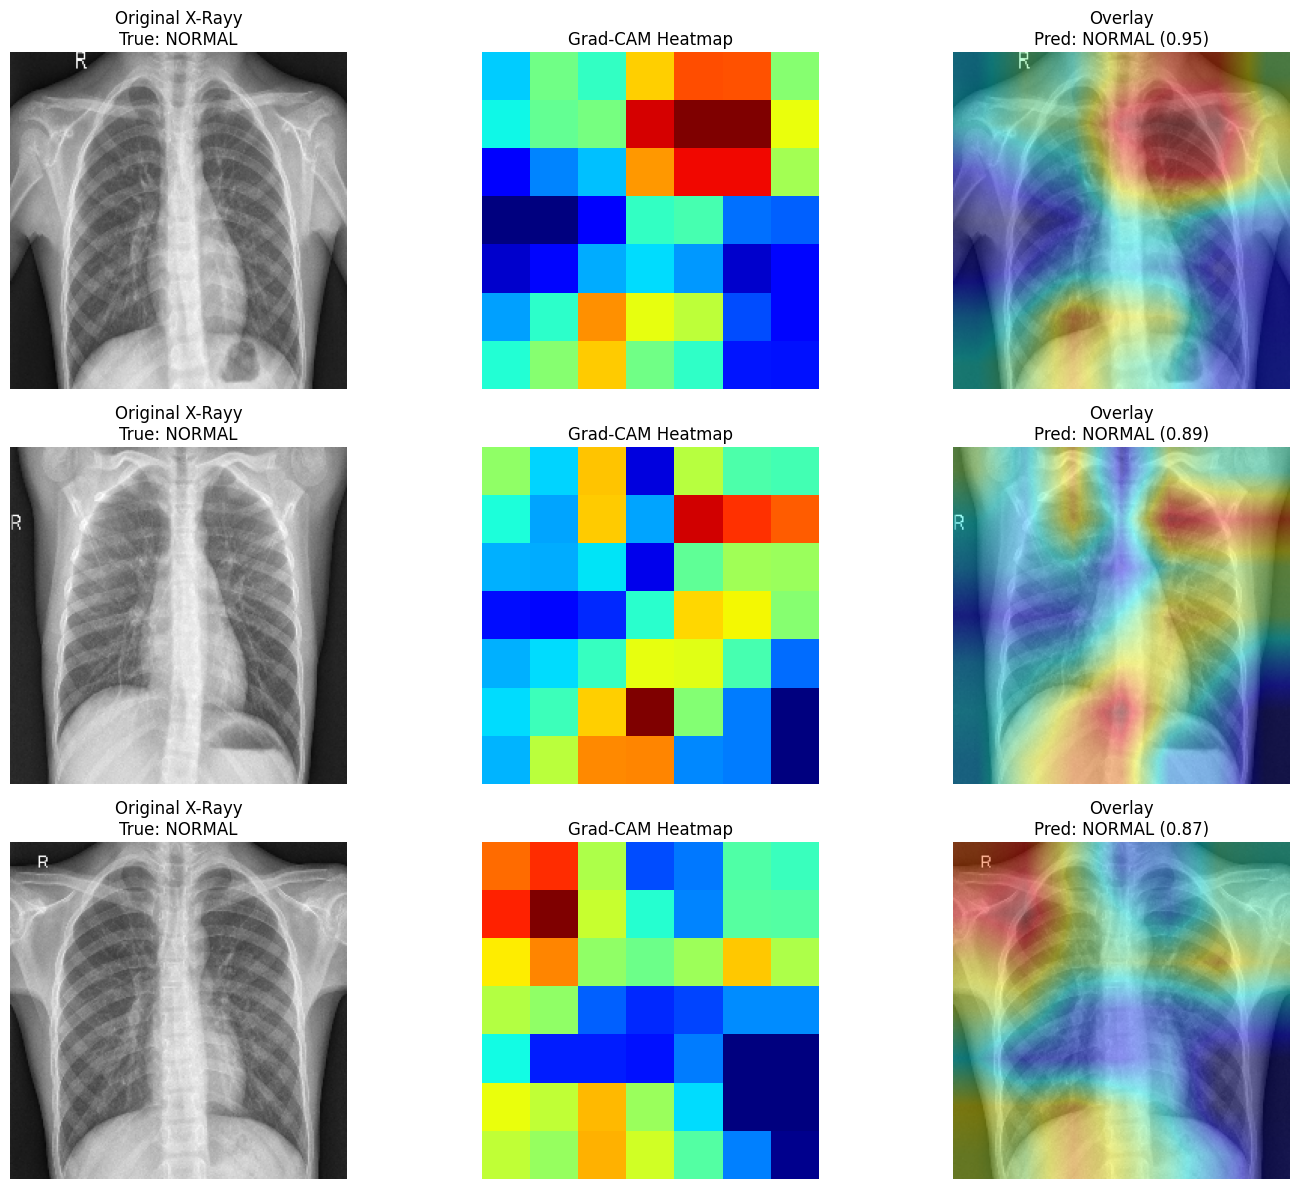

Grad-CAM visualizations complete!


In [ ]:
print("\nGenerating Grad-CAM visualizations....")
last_conv_layer = "conv5_block16_concat"

try:
  visualize_gradcam_samples(model,test_gen,last_conv_layer,num_samples=3)
  print("Grad-CAM visualizations complete!")
except Exception as e:
  print(f"Error generating Grad-CAM: {e}")
  print("Make sure the model is loaded and test_gen has data.")

**PHASE 8: TRAINING HISTORY VISUALIZATIONS**


Plotting training history...


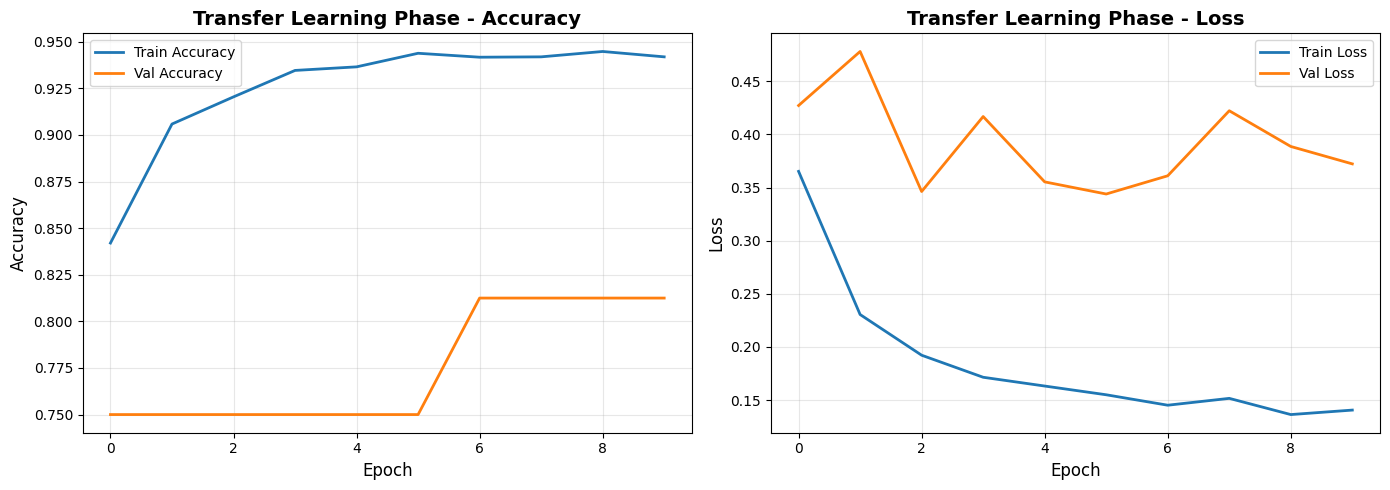

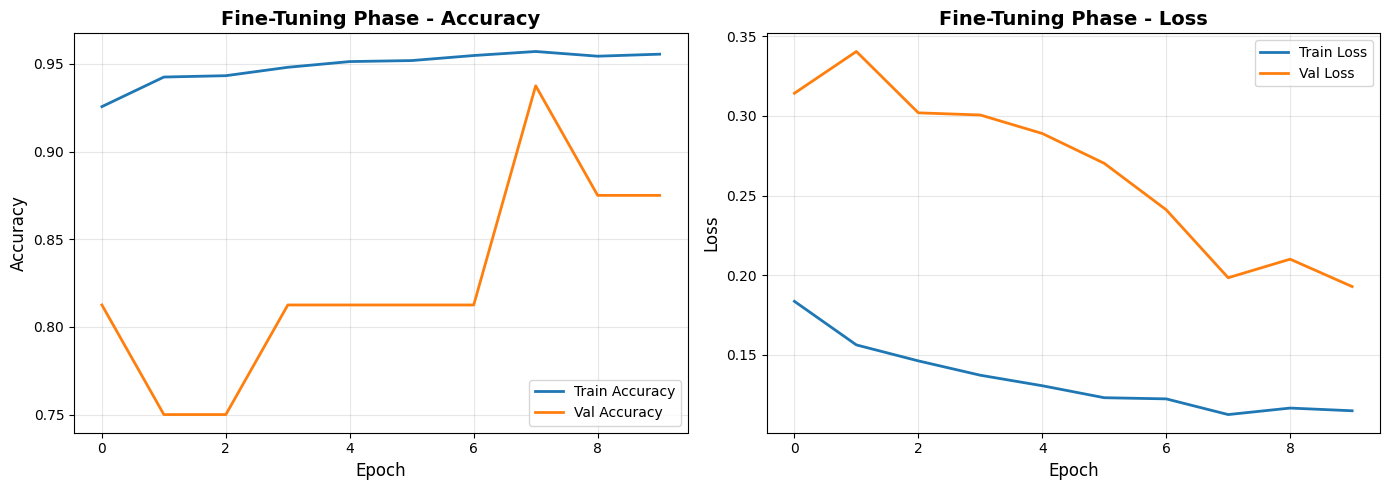


TRAINING COMPLETE!
✓ Baseline model saved: baseline_cnn_model.keras
✓ Final model saved: pneumonia_multiclass_densenet_model.keras
✓ Test Accuracy: 89.42%
✓ Sensitivity: 98.21%
✓ Specificity: 74.79%


In [ ]:
def plot_training_history(history, title="Training History"):
    """
    Plot training and validation accuracy/loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot both training phases
print("\nPlotting training history...")
plot_training_history(history_tl, "Transfer Learning Phase")
plot_training_history(history_ft, "Fine-Tuning Phase")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"✓ Baseline model saved: baseline_cnn_model.keras")
print(f"✓ Final model saved: pneumonia_multiclass_densenet_model.keras")
print(f"✓ Test Accuracy: {(tp + tn) / (tp + tn + fp + fn):.2%}")
print(f"✓ Sensitivity: {sensitivity:.2%}")
print(f"✓ Specificity: {specificity:.2%}")
print("="*60)